In [1]:
%load_ext autoreload
%autoreload 2

https://openaccess.uoc.edu/bitstream/10609/148363/3/miravecaTFG0623memoria.pdf

https://www.portalinmobiliario.com/robots.txt


SAAS
https://github.com/Saas-Starter-Kit/Saas-Kit-prisma?tab=readme-ov-file


In [2]:
import numpy as np
import pandas as pd
from time import sleep
from webscrapper_portal_inmobiliario import WebScraperPortalInmobiliario

### TODO:
- ~~trackear propiedades en el tiempo para el mismo sector  SE HACE CON LA [LAT LONG]~~
- ~~Sortear baneos de ip por muchas request - sectores con muchas propiedades~~
https://brightdata.com/cp/zones/residential_proxy1/edit 8 dolares el GB --> SOLUCION
- ~~crear tabla intetmedia con 3 tablas y generar id unico...~~
- ~~buscar estandar para nombres de columnas en tablas, en ingles... sin mayusculas~~
- ~~Hacer que se descarguen las cards urls totales [venta + arriendo]~~
- ~~Los polygonos se agregan a una tabla en la base de datos... con una funcion~~
- ~~para correr el programa se ejecuta otra funcion que leera los polygoinos de la base de datos~~
- ~~Que funcione descargando para multiples polygonos~~
- ~~Modo descarga casas y departamentos en conjunto~~
- ejecutar todos los links en async paralels request usando https://github.com/microsoft/playwright-python- 
---
- Calculos de estadicticas de rentabilidad
- rankear propiedades basado en esto
- grafico mapa donde se encuentran estas propiedades
- extraer imagenes del TOP 3 Propiedades
- plotear en single plot matplotlib. una especie de reporte automatico.




In [3]:
WSPI = WebScraperPortalInmobiliario()

## MAP HANDLING

CREATE NEW MAP GROUP

make a create, delete and edit cluster map function, diferent one for each action

In [4]:
# WSPI.insert_new_cluser_map("CLUSTER_3",None)

LIST MAPS AVALIABLE

In [5]:
WSPI.list_db_maps()

  mapID        geo_ref_name
0     1   general_arriagada
1     2      Diego_portales
2     3   atras_plaza_egaña
3     4               macul
4     5  la_florida_linea_9


LOAD A SELECTED MAP INTO VISUALIZATION

In [6]:
WSPI.vis_map(selected_mapID=5)

la_florida_linea_9 --> Sucess!


Map(center=[-33.54701335666667, -70.56571725555554], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [7]:
# WSPI.start_download(selected_mapID=3)

# TRAINING THE MODEL

In [57]:
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mpl.rcParams["figure.figsize"] = 20, 7
mpl.rcParams["xtick.color"] = "white"
mpl.rcParams["ytick.color"] = "white"
mpl.rcParams["xtick.labelcolor"] = "white"
mpl.rcParams["ytick.labelcolor"] = "white"
mpl.rcParams['text.color'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['axes.titlecolor'] = 'white'


# TODO BORRAR EL FINAL
mpl.rcParams["figure.figsize"] = 20, 7
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"
mpl.rcParams["xtick.labelcolor"] = "black"
mpl.rcParams["ytick.labelcolor"] = "black"
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['axes.titlecolor'] = 'black'

In [8]:
threshold_date = "01-01-2024"
WSPI.get_joined_data_as_dataframe(threshold_date,5)

In [65]:
# extract features
data = WSPI.df_analysis[["n_dormitorios","superficie_total","antiguedad", "tipo_inmueble", "Price_UF", "latitude", "longitude","tipo_operacion"]]
data.head()

,n_dormitorios,superficie_total,antiguedad,tipo_inmueble,Price_UF,latitude,longitude,tipo_operacion
0,3.0,220.0,0.0,casa,21.13,-33.561689,-70.559349,arriendo
1,6.0,180.0,NaN,casa,5.28,-33.558466,-70.557104,arriendo
2,4.0,145.0,0.0,casa,4100.00,-33.562807,-70.551059,venta
3,3.0,135.0,22.0,casa,3961.84,-33.561288,-70.558906,venta
4,4.0,200.0,15.0,casa,5018.32,-33.551910,-70.554457,venta


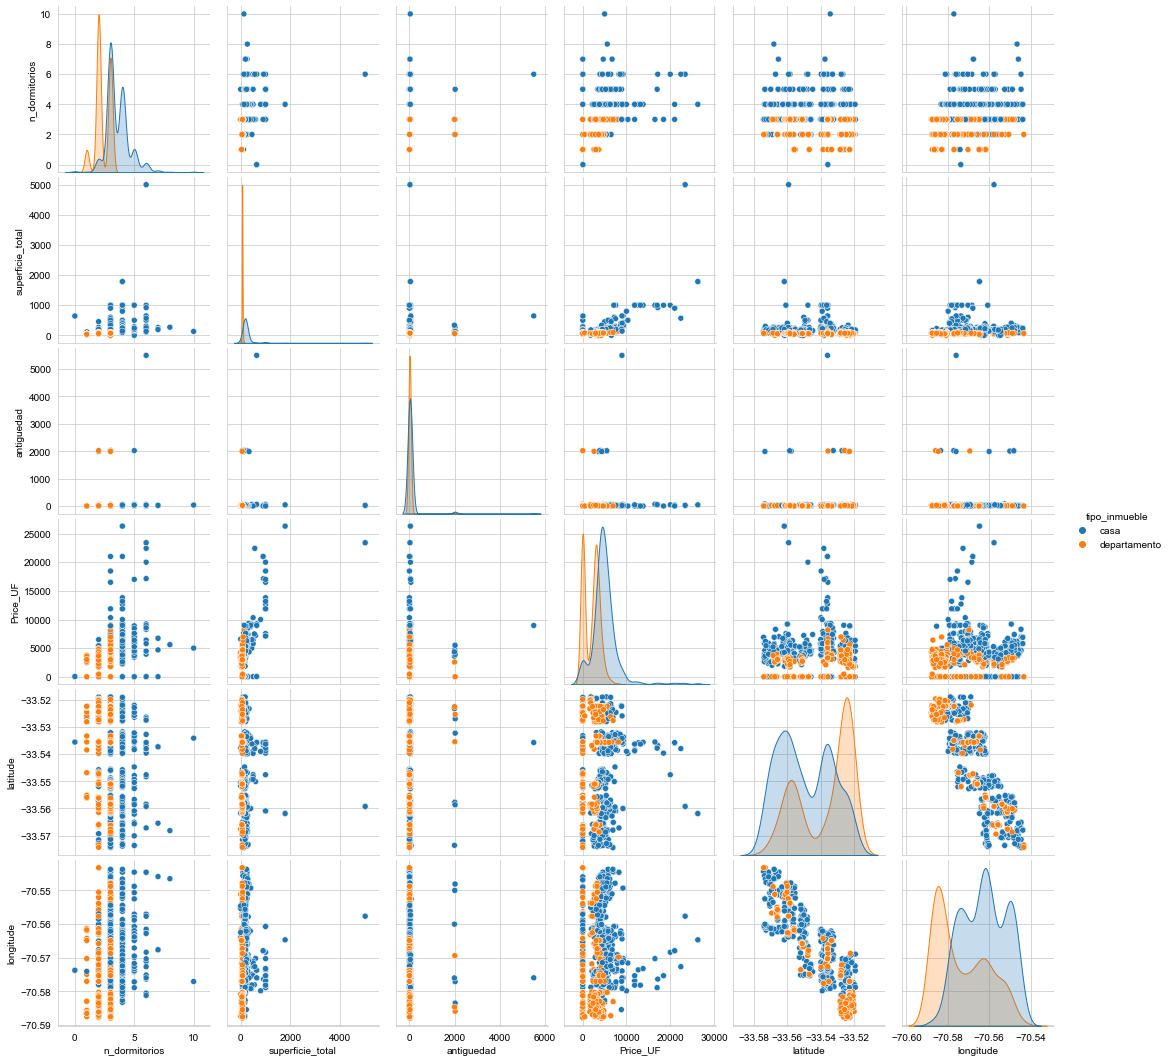

In [67]:
# analyzing the data
sns.pairplot(data.drop("tipo_operacion",axis=1), hue="tipo_inmueble")

In [69]:
# extract outliers
def remove_outliers(self, column_name):
    """ removedor de outliers para columna especificada"""
    Q1 = self[column_name].quantile(0.25)
    Q3 = self[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    condition = (self[column_name] >= lower_bound) & (self[column_name] <= upper_bound)
    return self.loc[condition]

pd.DataFrame.remove_outliers = remove_outliers

# we can see that "antiguedad" and "superficie_total" has outliers. lets remove them
clean_df = data.remove_outliers('superficie_total')
clean_df = clean_df.remove_outliers('antiguedad')

In [ ]:
clean_df['Categoria'] = clean_df['tipo_operacion'] + '_' + clean_df['tipo_inmueble']
sns.pairplot(clean_df.drop(["tipo_operacion","tipo_inmueble"],axis=1), hue="Categoria")
clean_df.drop("Categoria", axis=1, inplace=True)

Now it looks much better!

### MODEL TRAINING

In [92]:
import  xgboost
from sklearn.model_selection import train_test_split

In [93]:
# preparing categorical data
clean_df_final = pd.get_dummies(clean_df, columns=["tipo_inmueble"], drop_first=True)
clean_df_final = pd.get_dummies(clean_df_final, columns=["tipo_operacion"], drop_first=True)

In [104]:
# split in sell and rent for diferent model training
data_sell_value = clean_df_final.query("tipo_operacion_venta == 1").drop("tipo_operacion_venta", axis=1)
data_rent_value = clean_df_final.query("tipo_operacion_venta == 0").drop("tipo_operacion_venta", axis=1)

In [105]:
# split in X and Y data
x_data_sell = data_sell_value.drop(["Price_UF"], axis=1)
y_data_sell = data_sell_value[["Price_UF"]]

x_data_rent = data_rent_value.drop(["Price_UF"], axis=1)
y_data_rent = data_rent_value[["Price_UF"]]

In [106]:
# SELL MODEL
model_sell = xgboost.XGBRegressor()
# train test split
X_train, X_test, y_train, y_test = train_test_split(x_data_sell.values, y_data_sell.values, test_size=0.15, random_state=42)
# fit model
model_sell.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [107]:
# RENT MODEL
model_rent = xgboost.XGBRegressor()
X_train, X_test, y_train, y_test = train_test_split(x_data_rent.values, y_data_rent.values, test_size=0.15, random_state=42) # NOQA
model_rent.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

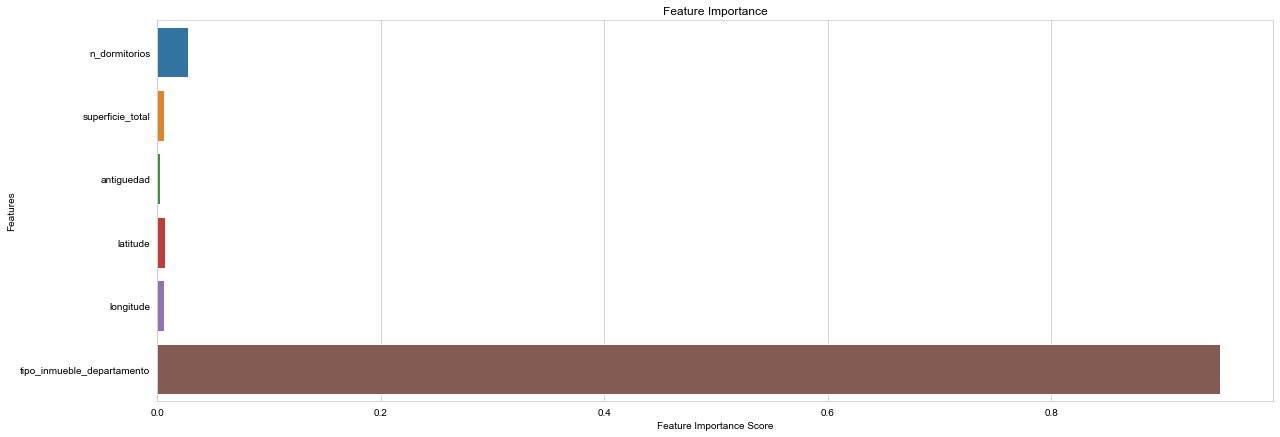

In [113]:
feature_importance = model_rent.feature_importances_
feature_names = x_data_rent.columns
# sns.barplot(x=feature_importance, y=feature_names)
# logaritmic barplot
sns.barplot(x=feature_importance, y=feature_names)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.show()

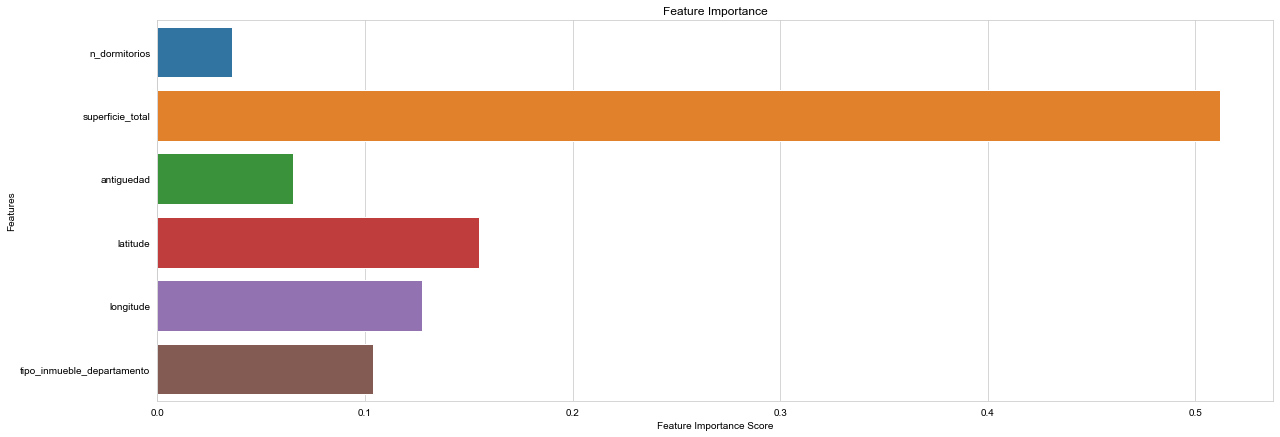

In [109]:
feature_importance = model_sell.feature_importances_
feature_names = x_data_sell.columns
sns.barplot(x=feature_importance, y=feature_names)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.show()

We could improve the model by using fine-tuning and also evaluate it more robustly with techniques like k-folds. However, for the purpose of this project, it performs quite well. Additionally, it aligns with the initial hypothesis regarding the variables

In [83]:
# get rmse
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 502.330789


In [84]:
# now r2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R2: %f" % (r2))

R2: 0.937353


# DATA MANAGE
------------------------------------------

# fix get caprates for macul datset

In [7]:
WSPI.get_df_caprates(map_id=5,threshold_date="2024-10-04")

analizando casa
con 0.0 dormitorios, se puede arrendar en aproximadamente 2123831, analizado desde 2 propiedades
con 2.0 dormitorios, se puede arrendar en aproximadamente 480000, analizado desde 3 propiedades
con 3.0 dormitorios, se puede arrendar en aproximadamente 550000, analizado desde 20 propiedades
con 4.0 dormitorios, se puede arrendar en aproximadamente 680000, analizado desde 5 propiedades
con 5.0 dormitorios, se puede arrendar en aproximadamente 850000, analizado desde 2 propiedades
con 6.0 dormitorios, se puede arrendar en aproximadamente 480000, analizado desde 3 propiedades
con 7.0 dormitorios, se puede arrendar en aproximadamente 1100000, analizado desde 1 propiedades
precio/m2 de la zona es 7946 CLP , 0.21 UF
-------------------------------------
analizando departamento
con 1.0 dormitorios, se puede arrendar en aproximadamente 330000, analizado desde 16 propiedades
con 2.0 dormitorios, se puede arrendar en aproximadamente 420000, analizado desde 100 propiedades
con 3.0 d

In [8]:
WSPI.df_analysis

,dias_desde_publicacion,n_dormitorios,n_banos,superficie_total,superficie_util,estacionamientos,bodegas,antiguedad,cantidad_pisos_edificio,piso_unidad,...,orientacion,gastos_comunes,link,listed,Price,Price_UF,tipo_operacion,Date,latitude,longitude
0,330.0,3.0,2.0,180.00,80.00,1.0,NaN,NaN,NaN,NaN,...,None,NaN,https://www.portalinmobiliario.com/MLC-1481828...,0,1.500000e+08,3955.12,venta,2024-10-04 17:45:11.727663,-33.557025,-70.558912
1,365.0,3.0,3.0,144.85,121.85,1.0,0.0,30.0,2.0,NaN,...,NP,0.0,https://www.portalinmobiliario.com/MLC-1508981...,0,1.540000e+08,4060.59,venta,2024-10-04 17:45:11.793806,-33.556843,-70.558876
2,14.0,2.0,1.0,190.00,80.00,1.0,1.0,29.0,1.0,NaN,...,-,NaN,https://www.portalinmobiliario.com/MLC-2704958...,0,1.393006e+08,3673.00,venta,2024-10-04 17:45:11.854552,-33.556979,-70.563050
3,29.0,3.0,1.0,200.00,80.00,1.0,1.0,0.0,0.0,NaN,...,-,0.0,https://www.portalinmobiliario.com/MLC-1521986...,0,1.380000e+08,3638.71,venta,2024-10-04 17:45:11.866301,-33.557052,-70.563503
4,7.0,5.0,3.0,1000.00,350.00,8.0,1.0,NaN,2.0,NaN,...,None,NaN,https://www.portalinmobiliario.com/MLC-1530295...,0,2.700000e+08,7119.21,venta,2024-10-04 17:45:11.902177,-33.560923,-70.560726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,10.0,2.0,2.0,80.00,60.00,1.0,NaN,6.0,NaN,NaN,...,N,100000.0,https://www.portalinmobiliario.com/MLC-2709037...,1,1.479097e+08,3900.00,venta,2024-10-04 19:36:14.443474,-33.524427,-70.586226
926,6.0,2.0,1.0,54.00,54.00,1.0,NaN,7.0,NaN,4.0,...,SO,110000.0,https://www.portalinmobiliario.com/MLC-1530790...,1,1.384283e+08,3650.00,venta,2024-10-04 19:36:14.453402,-33.527372,-70.586150
927,4.0,3.0,2.0,73.23,70.00,1.0,1.0,10.0,4.0,2.0,...,NO,100000.0,https://www.portalinmobiliario.com/MLC-2719591...,1,1.801464e+08,4750.00,venta,2024-10-04 19:36:14.463920,-33.523629,-70.587574
928,25.0,3.0,2.0,78.00,68.05,1.0,1.0,2.0,6.0,10.0,...,NO,100000.0,https://www.portalinmobiliario.com/MLC-2692065...,1,1.782501e+08,4700.00,venta,2024-10-04 19:36:14.474347,-33.527783,-70.575319


Text(0.5, 0.98, 'Distribution of prices by number of dorms')

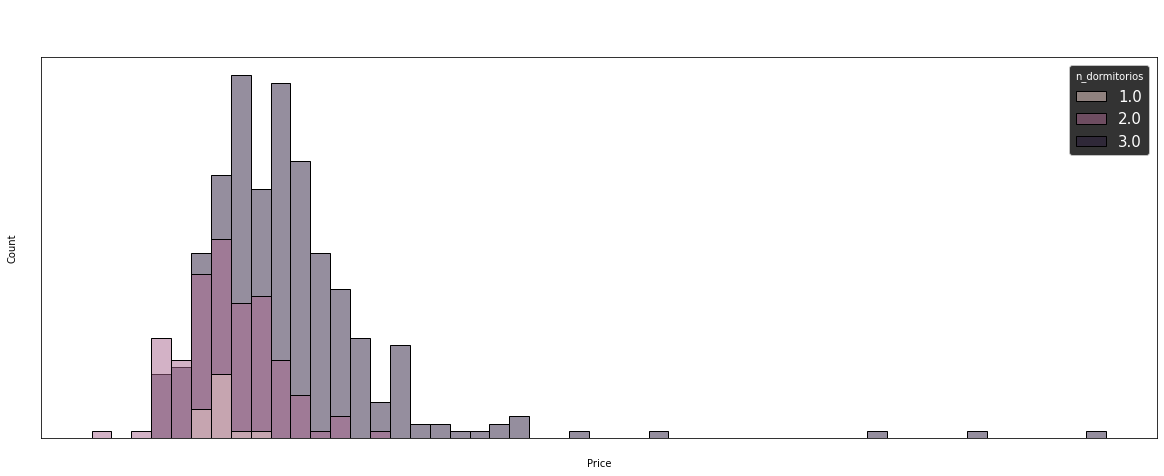

In [45]:
# histogram prices vs tipology
import matplotlib.pyplot as plt
import seaborn as sns
figure,ax = plt.subplots(figsize=(20,7))

import matplotlib as mpl

# ONLY IF USING JUPYTER BLACK
mpl.rcParams["figure.figsize"] = 20, 7
mpl.rcParams["xtick.color"] = "white"
mpl.rcParams["ytick.color"] = "white"
mpl.rcParams["xtick.labelcolor"] = "white"
mpl.rcParams["ytick.labelcolor"] = "white"
mpl.rcParams['text.color'] = "white"
# make thge legend of the plot white text too using mpl
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.facecolor'] = 'black'



sns.histplot(data=WSPI.df_analysis.query("tipo_operacion=='venta' and n_dormitorios <= 3 and n_dormitorios > 0"), x="Price", hue="n_dormitorios", element="bars")
figure.suptitle("Distribution of prices by number of dorms", fontsize=20)

Text(0.5, 1.0, 'Prices by latitude')

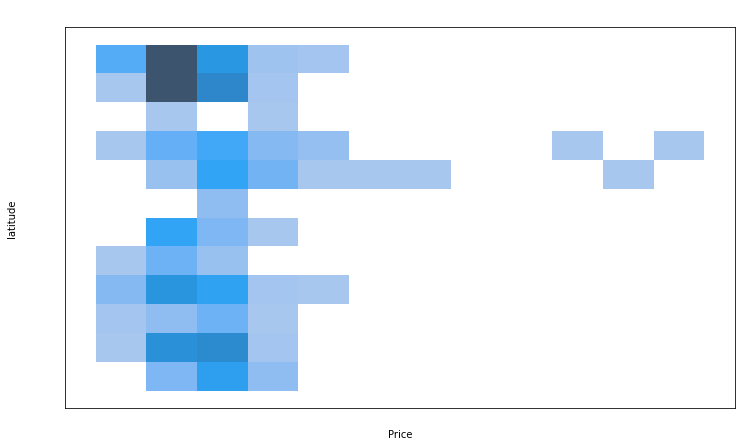

In [60]:
figure,ax = plt.subplots(figsize=(12,7))
sns.histplot(data=WSPI.df_analysis.query("tipo_operacion=='venta' and n_dormitorios <= 3 and n_dormitorios > 0"), x="Price",y="latitude",ax=ax,bins=12, legend=True)
ax.set_title("Prices by latitude", fontsize=20)


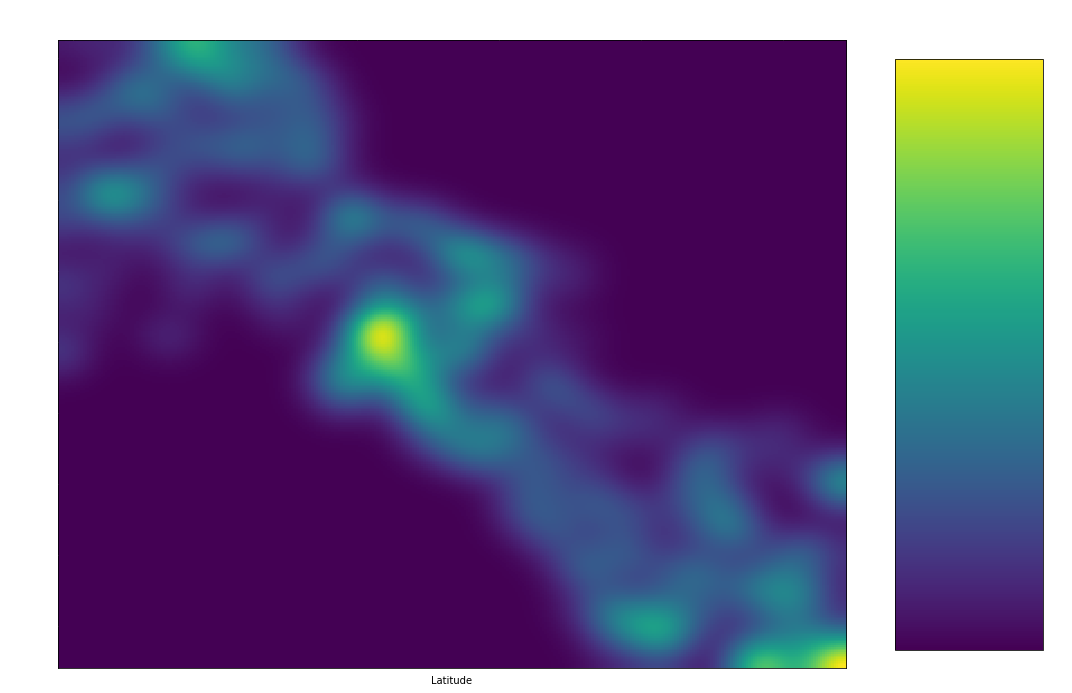

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.ndimage import gaussian_filter
import pandas as pd

# Sample DataFrame
data = WSPI.df_analysis.query("tipo_operacion=='venta' and n_dormitorios <= 3 and n_dormitorios > 0")
data["latitude"] = data["latitude"] * -1

# Create a pivot table to create a grid of Price values
pivot_table = data.pivot_table(index='longitude', columns='latitude', values='Price')

# Convert pivot table to a numpy array, filling NaNs with 0
sparse_matrix = pivot_table.to_numpy()
sparse_matrix[np.isnan(sparse_matrix)] = 0

# Smooth the matrix
smoothed_matrix = gaussian_filter(sparse_matrix, sigma=11)

# Set 0s to None as they will be ignored when plotting
sparse_matrix[sparse_matrix == 0] = None

# Plot the data
fig, ax2 = plt.subplots( figsize=(15, 15))

# # Plot the original matrix
# cax1 = ax1.matshow(sparse_matrix, extent=[pivot_table.columns.min(), pivot_table.columns.max(), pivot_table.index.min(), pivot_table.index.max()])
# ax1.set_title("Original matrix")
# ax1.set_xlabel("Latitude")
# ax1.set_ylabel("Longitude")
# fig.colorbar(cax1, ax=ax1, shrink=0.8, aspect=4)

# Plot the smoothed matrix
cax2 = ax2.matshow(smoothed_matrix, extent=[pivot_table.columns.min(), pivot_table.columns.max(), pivot_table.index.min(), pivot_table.index.max()])
ax2.set_title("Smoothed matrix")
ax2.set_xlabel("Latitude")
fig.colorbar(cax2, ax=ax2, shrink=0.8, aspect=4)

plt.tight_layout()
plt.show()

# PRICE PLOTING

In [103]:
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import numpy as np

df = WSPI.df_analysis.query("tipo_operacion == 'venta'")[['latitude', 'longitude', 'Price']].copy()
df.rename(columns = {"Price":"price"},inplace = True)

def plot_real_estate_map(df, output_file='real_estate_map.html', lower_percentile=5, upper_percentile=95,color_column = 'price'):
    """
    Plots a map with real estate data.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'latitude', 'longitude', and 'price' columns.
        output_file (str): The output HTML file to save the map.
        lower_percentile (int): Lower percentile cutoff for price to ignore outliers.
        upper_percentile (int): Upper percentile cutoff for price to ignore outliers.
    """
    
    # Calculate the lower and upper percentile cutoffs
    lower_cutoff = np.percentile(df[color_column], lower_percentile)
    upper_cutoff = np.percentile(df[color_column], upper_percentile)

    # Filter the dataframe to exclude outliers
    filtered_df = df[(df[color_column] >= lower_cutoff) & (df[color_column] <= upper_cutoff)]

    # Normalize price for coloring
    min_price = filtered_df[color_column].min()
    max_price = filtered_df[color_column].max()

    def get_color(price):
        # Normalize the price to 0-1 range
        norm_price = (price - min_price) / (max_price - min_price)
        # Get color from red (expensive) to green (cheap)
        return plt.cm.RdYlGn(1 - norm_price)

    # Create a map centered around the mean latitude and longitude
    # m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=5)
    m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=5, tiles='cartodb dark_matter')

    # Add markers
    for _, row in df.iterrows():
        if lower_cutoff <= row[color_column] <= upper_cutoff:
            color = get_color(row[color_column])
            color_hex = f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}'
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=3,
                color=color_hex,
                fill=True,
                fill_color=color_hex
            ).add_to(m)

    # Save the map to an HTML file
    m.save(output_file)

plot_real_estate_map(df, output_file='real_estate_map.html')

In [71]:
def plot_real_estate_map(df, output_file='real_estate_map.html', lower_percentile=5, upper_percentile=95, num_bins=5,color_column = 'price'):
    """
    Plots a map with real estate data.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'latitude', 'longitude', and 'price' columns.
        output_file (str): The output HTML file to save the map.
        lower_percentile (int): Lower percentile cutoff for price to ignore outliers.
        upper_percentile (int): Upper percentile cutoff for price to ignore outliers.
        num_bins (int): Number of discrete color bins to use.
    """

    # Calculate the lower and upper percentile cutoffs
    lower_cutoff = np.percentile(df[color_column], lower_percentile)
    upper_cutoff = np.percentile(df[color_column], upper_percentile)

    # Filter the dataframe to exclude outliers
    filtered_df = df[(df[color_column] >= lower_cutoff) & (df[color_column] <= upper_cutoff)]

    # Normalize price for coloring
    min_price = filtered_df[color_column].min()
    max_price = filtered_df[color_column].max()

    def get_color(price):
        # Normalize the price to 0-1 range
        norm_price = (price - min_price) / (max_price - min_price)
        # Quantize the normalized price into discrete bins
        bin_idx = int(norm_price * (num_bins - 1))
        # Get color from RdYlGn colormap
        return plt.cm.RdYlGn(bin_idx / (num_bins - 1))

    # Create a map centered around the mean latitude and longitude
    m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=5, tiles='cartodb dark_matter')

    # Add markers
    for _, row in df.iterrows():
        if lower_cutoff <= row[color_column] <= upper_cutoff:
            color = get_color(row[color_column])
            color_hex = f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}'
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=10,
                color=color_hex,
                fill=True,
                fill_color=color_hex
            ).add_to(m)

    # Save the map to an HTML file
    m.save(output_file)

# clusterization

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [72]:
scaler = StandardScaler()

df = WSPI.df_analysis[['latitude', 'longitude', 'Price']].copy()
df.rename(columns = {"Price":"price"},inplace = True)

df_raw = df.copy()
df[[ 'price', 'latitude', 'longitude']] = scaler.fit_transform(df[[ 'price', 'latitude', 'longitude']])

# df = pd.get_dummies(df, columns=['tipo_inmueble'], drop_first=True)

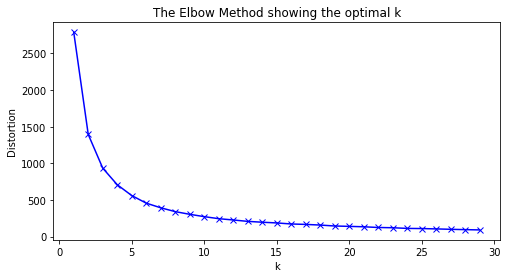

In [75]:
def elbow_method(data):
    distortions = []
    K = range(1, 30)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

# Apply elbow method
elbow_method(df)

In [76]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_raw['cluster'] = kmeans.fit_predict(df)
plot_real_estate_map(df=df_raw, output_file='clusterization.html',color_column='cluster',num_bins=6)

# caprate analysis

In [105]:
WSPI.analysis_results["df_caprate_casa"]#.query("n_dormitorios >= 3 and caprate_bruto > 0.06 and  Price < 150e6 and Price > 110e6")

,dias_desde_publicacion,n_dormitorios,n_banos,superficie_total,superficie_util,estacionamientos,bodegas,antiguedad,cantidad_pisos_edificio,piso_unidad,...,gastos_comunes,link,listed,Price,Price_UF,tipo_operacion,Date,latitude,longitude,caprate_bruto
0,330.0,3.0,2.0,180.00,80.00,1.0,NaN,NaN,NaN,NaN,...,NaN,https://www.portalinmobiliario.com/MLC-1481828...,0,1.500000e+08,3955.12,venta,2024-10-04 17:45:11.727663,-33.557025,-70.558912,0.044000
1,365.0,3.0,3.0,144.85,121.85,1.0,0.0,30.0,2.0,NaN,...,0.0,https://www.portalinmobiliario.com/MLC-1508981...,0,1.540000e+08,4060.59,venta,2024-10-04 17:45:11.793806,-33.556843,-70.558876,0.042857
2,14.0,2.0,1.0,190.00,80.00,1.0,1.0,29.0,1.0,NaN,...,NaN,https://www.portalinmobiliario.com/MLC-2704958...,0,1.393006e+08,3673.00,venta,2024-10-04 17:45:11.854552,-33.556979,-70.563050,0.041349
3,29.0,3.0,1.0,200.00,80.00,1.0,1.0,0.0,0.0,NaN,...,0.0,https://www.portalinmobiliario.com/MLC-1521986...,0,1.380000e+08,3638.71,venta,2024-10-04 17:45:11.866301,-33.557052,-70.563503,0.047826
4,7.0,5.0,3.0,1000.00,350.00,8.0,1.0,NaN,2.0,NaN,...,NaN,https://www.portalinmobiliario.com/MLC-1530295...,0,2.700000e+08,7119.21,venta,2024-10-04 17:45:11.902177,-33.560923,-70.560726,0.037778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,365.0,3.0,2.0,200.00,110.00,3.0,0.0,30.0,1.0,NaN,...,0.0,https://www.portalinmobiliario.com/MLC-2684047...,1,2.010055e+08,5300.00,venta,2024-10-04 19:36:11.699772,-33.524972,-70.576863,0.032835
683,90.0,3.0,2.0,160.00,65.00,2.0,1.0,42.0,1.0,NaN,...,NaN,https://www.portalinmobiliario.com/MLC-2492203...,1,1.649762e+08,4350.00,venta,2024-10-04 19:36:11.709639,-33.523775,-70.587382,0.040006
684,57.0,4.0,2.0,140.00,110.00,1.0,NaN,NaN,NaN,NaN,...,NaN,https://www.portalinmobiliario.com/MLC-1528693...,1,1.450000e+08,3823.28,venta,2024-10-04 19:36:11.721537,-33.526299,-70.574031,0.056276
685,29.0,3.0,2.0,180.00,72.00,1.0,0.0,40.0,1.0,NaN,...,0.0,https://www.portalinmobiliario.com/MLC-2687624...,1,7.054154e+07,1860.00,venta,2024-10-04 19:36:11.733395,-33.518949,-70.578795,0.093562


In [102]:
WSPI.analysis_results["df_caprate_casa"].query("link=='https://www.portalinmobiliario.com/MLC-1491546889-vendo-casa-4d-1b-parque-residencial-valle-del-sol-pte-alto-_JM#position%3D41%26search_layout%3Dmap%26type%3Ditem%26tracking_id%3Dd0ebad87-f83c-4306-af7f-4f9a774f21a5'")

,dias_desde_publicacion,n_dormitorios,n_banos,superficie_total,superficie_util,estacionamientos,bodegas,antiguedad,cantidad_pisos_edificio,piso_unidad,...,gastos_comunes,link,listed,Price,Price_UF,tipo_operacion,Date,latitude,longitude,caprate_bruto
6,90.0,4.0,1.0,137.0,74.0,1.0,2.0,24.0,1.0,NaN,...,0.0,https://www.portalinmobiliario.com/MLC-1491546...,0,128946904.0,3400.0,venta,2024-10-04 17:45:12.010780,-33.556481,-70.559797,0.063282
228,90.0,4.0,1.0,137.0,74.0,1.0,2.0,24.0,1.0,NaN,...,0.0,https://www.portalinmobiliario.com/MLC-1491546...,0,128946904.0,3400.0,venta,2024-10-04 18:38:13.480053,-33.556481,-70.559797,0.063282


In [98]:
WSPI.analysis_results["df_caprate_departamento"].query("n_dormitorios >= 3 and caprate_bruto > 0.055 and  Price < 150e6 ")

,dias_desde_publicacion,n_dormitorios,n_banos,superficie_total,superficie_util,estacionamientos,bodegas,antiguedad,cantidad_pisos_edificio,piso_unidad,...,gastos_comunes,link,listed,Price,Price_UF,tipo_operacion,Date,latitude,longitude,caprate_bruto
170,49.0,3.0,2.0,66.0,64.0,2.0,0.0,9.0,0.0,0.0,...,NaN,https://www.portalinmobiliario.com/MLC-1515006...,0,94586346.64,2494.00,venta,2024-10-04 18:31:57.389597,-33.567636,-70.551188,0.057091
278,120.0,3.0,1.0,50.0,45.0,0.0,0.0,13.0,NaN,NaN,...,35000.0,https://www.portalinmobiliario.com/MLC-2423882...,0,70000000.00,1845.72,venta,2024-10-04 18:38:14.083799,-33.558453,-70.553825,0.077143
282,150.0,3.0,2.0,70.0,67.0,1.0,NaN,NaN,NaN,1.0,...,70000.0,https://www.portalinmobiliario.com/MLC-1480686...,0,97000000.00,2557.64,venta,2024-10-04 18:38:14.129718,-33.559250,-70.552528,0.055670
292,120.0,3.0,1.0,66.0,64.0,0.0,NaN,NaN,NaN,NaN,...,40000.0,https://www.portalinmobiliario.com/MLC-1484715...,0,65000000.00,1713.88,venta,2024-10-04 18:38:14.252860,-33.558453,-70.553825,0.083077
299,1.0,3.0,1.0,52.0,50.0,1.0,1.0,NaN,NaN,NaN,...,50000.0,https://www.portalinmobiliario.com/MLC-1532369...,0,84000000.00,2214.87,venta,2024-10-04 18:38:14.324617,-33.559287,-70.557687,0.064286
304,11.0,3.0,2.0,56.0,54.0,1.0,0.0,15.0,1.0,4.0,...,40500.0,https://www.portalinmobiliario.com/MLC-1528523...,0,80600000.00,2125.22,venta,2024-10-04 18:38:14.378186,-33.558453,-70.553825,0.066998
400,120.0,3.0,2.0,60.0,60.0,1.0,0.0,NaN,NaN,NaN,...,55000.0,https://www.portalinmobiliario.com/MLC-1490296...,0,96500000.00,2544.46,venta,2024-10-04 18:43:46.251205,-33.551022,-70.565821,0.055959
403,25.0,3.0,2.0,61.0,58.0,0.0,0.0,17.0,22.0,NaN,...,70000.0,https://www.portalinmobiliario.com/MLC-2692119...,0,96710178.00,2550.00,venta,2024-10-04 18:43:46.287229,-33.551971,-70.573585,0.055837
798,43.0,3.0,1.0,52.0,52.0,1.0,NaN,NaN,NaN,NaN,...,0.0,https://www.portalinmobiliario.com/MLC-2668958...,1,79000000.00,2083.03,venta,2024-10-04 19:36:13.044625,-33.520620,-70.580162,0.068354
843,120.0,3.0,1.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,...,0.0,https://www.portalinmobiliario.com/MLC-2458497...,1,68000000.00,1792.99,venta,2024-10-04 19:36:13.544884,-33.520216,-70.584800,0.079412


# APRENDIZAJES


webdriver
2. es bueno reiniciar y cerrar el driver
2. el estado de la pagina (restricciones) cambiara solo con el refresh!!
3. Si se aplica un init y luego get/request no retornara NADA (PUEDE QUE SI PERO EN GENERAL NO PORQUE ES UN USER NUEVO SE ASOCIARA CON WEBSCRAPPING)
4. el orden correcto sera

close--> init--> request (primera vez ,  alta probabilida de falla) -->  refresh (recarga y se puede obtener la tabla y ubicaciion)

#### aveces el http de inspeccionar no te dice realmente los codigos para la extraccion. revisar desde el json